In [7]:
# Import libraries

import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import peakutils as pkuts
from scipy import fftpack
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq
from matplotlib.offsetbox import AnchoredOffsetbox
import datetime as datetime
from datetime import datetime, timedelta
import os
import ctypes
import imufusion
import sys
from tqdm import tqdm
from scipy.signal import firwin
from ipywidgets import IntSlider, interact
from IPython.display import clear_output

In [8]:
### Functions ###

def freq_axis(fdata):
    xf = fftfreq(len(fdata), fs)[:len(fdata)//2]
    xf = np.linspace(0,fs/2,int(np.floor(len(fdata/2)+1)))
    return xf


def butter_bandpass(lowcut_hr, highcut_hr, fs, order=4):
        nyq = 0.5 * fs
        low = lowcut_hr / nyq
        high = highcut_hr / nyq
        sos = signal.butter(order, [low, high], btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, name, lowcut_hr, highcut_hr, fs, order=4, plot=False):
        sos = butter_bandpass(lowcut_hr, highcut_hr, fs, order=order)
        y = signal.sosfiltfilt(sos, data)

        ## TODO: Plot a graph of freq domain data
        xhz = freq_axis(data)
        # print('Hello xhz', xhz, '\nxhz shape', xhz.shape)
        yhz = 2*np.abs(fftpack.fft(y))

        if plot:
        # print('Hello yhz', yhz.shape, 'and', yhz.size)
            plt.plot(xhz[:len(yhz)],yhz[:len(yhz)])
            plt.title(f'FFT Plot {name} (post bandpass filter)')
            plt.xlabel('Frequency (Hz)'), plt.ylabel('Amplitude (AU)')
            plt.grid(True),plt.tick_params(axis='both', which='major', labelsize='small')
        
        # plt.savefig(f'fftpostbandpass{name}_{todaysdate}.svg')
        # plt.clf()
        return y

In [9]:
### Parameters

fs = 104 # sampling frequency

# Numbers used in Gio's experiment

# lowcut_hr = 0.67 # heart rate lower bound for bandpass filtering
# highcut_hr = 1.58 # heart rate upper bound for bandpass filtering
# lowcut_rr = 0.15 # respiratory rate lower bound for bandpass filtering
# highcut_rr = 0.42 # respiratory rate upper bound for bandpass filtering

# From image about Pig Vitals under anesthesia
lowcut_hr = 1 # heart rate lower bound for bandpass filtering
highcut_hr = 2 # heart rate upper bound for bandpass filtering
lowcut_rr = 0.33 # respiratory rate lower bound for bandpass filtering
highcut_rr = 0.66 # respiratory rate upper bound for bandpass filtering

In [10]:
### Set up Data Frame ###

# ### 2024
study_time_str = '09192024 09:36:57.026'
study_time = pd.to_datetime(study_time_str, format='%m%d%Y %H:%M:%S.%f')
file = r"C:\Users\krisf\OneDrive\Desktop\UROP SU25\Ceara sleep detection\Modified Data\processed09192024\modified_processed09192024.csv"

header = 0
data = pd.read_csv(
  file, header = header,
  parse_dates=['Time'],
  dtype={
    'XL_X': float, 'XL_Y': float, 'XL_Z': float,
    'G_X': float,  'G_Y': float,  'G_Z': float,
    'Temperature': float, 'Voltage': float, 'Packet': int
  },
    delimiter = ',',
)
df = pd.DataFrame(data, columns=["Time", 'XL_X', 'XL_Y', 'XL_Z',
    'G_X',  'G_Y',  'G_Z',
    'Temperature', 'Voltage', 'Packet'])
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S.%f')

##############

### Jan 2025
# study_time_str = '01162025 09:18:38.444'
# study_time = pd.to_datetime(study_time_str, format='%m%d%Y %H:%M:%S.%f')
# file = r"C:\Users\krisf\OneDrive\Desktop\UROP SU25\Ceara sleep detection\Data\processed011620252\01162025_imuprocessed.csv"

# header = 0
# data = pd.read_csv(
#   file, header = header,
#   dtype={
#     'Time': str, 'XL_X': str, 'XL_Y': str, 'XL_Z': str,
#     'G_X': str,  'G_Y': str,  'G_Z': str,
#     'Temperature': str, 'Voltage': str, 'Packet': int
#   },
#     delimiter = ',',
# )

# df = pd.DataFrame(data, columns=["Time", 'XL_X', 'XL_Y', 'XL_Z',
#     'G_X',  'G_Y',  'G_Z',
#     'Temperature', 'Voltage','Packet'])

# df = df[~df.eq('N').any(axis=1)].copy()

# cols = ['XL_X','XL_Y','XL_Z',
#         'G_X','G_Y','G_Z',
#         'Temperature','Voltage','Packet']
# df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S.%f')



##########

# ### July 2025
# study_time_str = '07022025 08:35:26.300'
# study_time = pd.to_datetime(study_time_str, format='%m%d%Y %H:%M:%S.%f')
# file = r"C:\Users\krisf\OneDrive\Desktop\UROP SU25\Ceara sleep detection\Modified Data\processed07022025\07022025_imuprocessed.csv"

# header = 0
# data = pd.read_csv(
#   file, header = header,
#   parse_dates=['Time'],
#   dtype={
#     'XL_X': str, 'XL_Y': str, 'XL_Z': str,
#     'G_X': str,  'G_Y': str,  'G_Z': str,
#     'Temperature': str, 'Voltage': str, 'Packet': int
#   },
#     delimiter = ',',
# )
# df = pd.DataFrame(data, columns=["Time", 'XL_X', 'XL_Y', 'XL_Z',
#     'G_X',  'G_Y',  'G_Z',
#     'Temperature', 'Voltage', 'Packet'])

# cols = ['XL_X','XL_Y','XL_Z',
#         'G_X','G_Y','G_Z',
#         'Temperature','Voltage','Packet']
# df.dropna(axis=0, how='any', inplace=True)
# df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
# df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S.%f')

In [ ]:
df.iloc[2096]

In [11]:
### Extrapolate time functions ###
def extrapolate_time(data, sampling_frequency):
    """
    Given a DataFrame `data` with a DateTime column 'Time', 
    return a DatetimeIndex of the same length as `data`,
    starting at the first timestamp and spaced by 1/sampling_frequency seconds.
    """
    # ensure Time is a datetime64 dtype
    data = data.copy()
    data['Time'] = pd.to_datetime(data['Time'])

    n = len(data)
    start = data['Time'].iloc[0]

    # pandas Timedelta for one sample interval
    interval = pd.to_timedelta(1 / sampling_frequency, unit='s')

    # build an evenly spaced index
    return pd.date_range(start=start, periods=n, freq=interval)

def extrapolate_time2(data, sampling_frequency):
    """
    Given a DataFrame `data` with a DateTime column 'Time', 
    return a DatetimeIndex of the same length as `data`,
    starting at the first timestamp and spaced by 1/sampling_frequency seconds
    for every interval of repeated timestamps.
    """
    # ensure Time is a datetime64 dtype
    times = data['Time']
    slot = data.groupby('Time').cumcount()
    dt = pd.to_timedelta(1 / sampling_frequency, unit='s')
    new_times = times + slot * dt
    return pd.DatetimeIndex(new_times)

In [13]:
### Extrapolate times ###

# times = df['Time']
# slot = df.groupby('Time').cumcount()
# slot.head(10)

# usage
new_times = extrapolate_time(df, sampling_frequency=104)
df['Time'] = new_times
df

delta = df['Time'] - study_time
df['Seconds'] = delta.dt.total_seconds()
df['Seconds'] = pd.to_numeric(df['Seconds'], errors="coerce")
# df[df['Seconds']>1251.17]

df

,Time,XL_X,XL_Y,XL_Z,G_X,G_Y,G_Z,Temperature,Voltage,Packet,Seconds
0,2024-09-19 09:36:57.026000000,-0.97,0.16,0.25,-57.26,-69.02,-46.87,30.0,2.96,19102,0.000000
1,2024-09-19 09:36:57.035615385,-0.95,0.14,0.26,-50.12,-58.70,-26.07,30.0,2.96,19102,0.009615
2,2024-09-19 09:36:57.045230770,-0.94,0.13,0.26,-41.72,-28.63,-8.44,30.0,2.96,19103,0.019231
3,2024-09-19 09:36:57.054846155,-0.95,0.13,0.25,-30.41,17.43,4.34,30.0,2.96,19103,0.028846
4,2024-09-19 09:36:57.064461540,-0.94,0.09,0.27,-10.32,66.50,7.98,30.0,2.96,19104,0.038462
...,...,...,...,...,...,...,...,...,...,...,...
282175,2024-09-19 10:22:10.247262375,-0.18,-0.44,-0.82,-14.42,1.65,9.06,41.0,3.05,41397,2713.221262
282176,2024-09-19 10:22:10.256877760,-0.09,-0.45,-0.97,-11.90,29.82,28.39,41.0,3.05,41401,2713.230878
282177,2024-09-19 10:22:10.266493145,-0.10,-0.44,-0.95,0.81,45.85,26.18,41.0,3.05,41401,2713.240493
282178,2024-09-19 10:22:10.276108530,-0.08,-0.39,-0.91,15.44,25.55,13.82,41.0,3.05,41403,2713.250109


Text(0, 0.5, 'Raw Data')

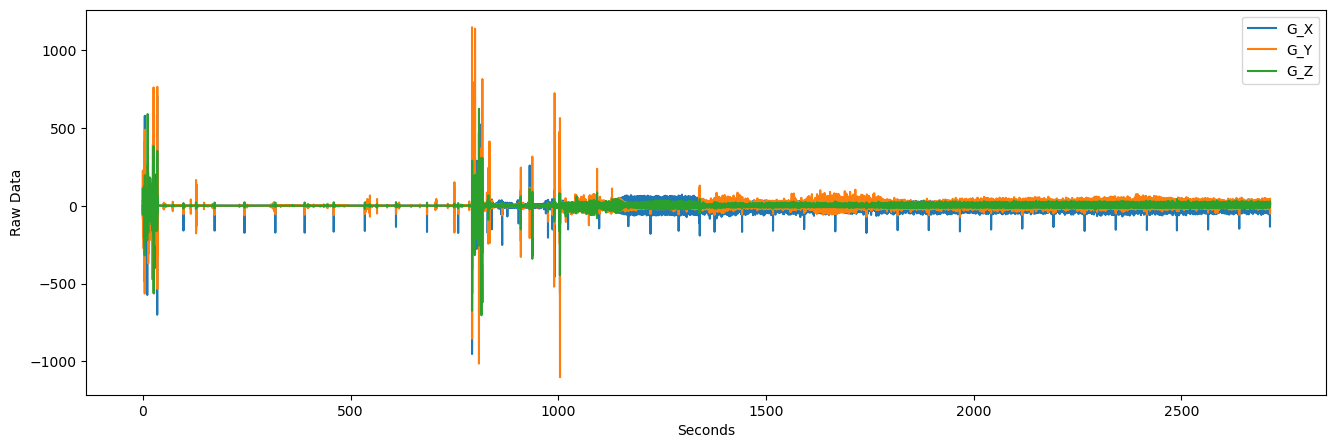

In [14]:
### Viusalize data
df.plot(x='Seconds', y = ['G_X',  'G_Y',  'G_Z'], figsize=(16,5))
plt.ylabel('Raw Data')
# plt.xlim(1250, 1252)
# plt.ylim(-100,100)


In [15]:
### Only use data starting at certain point ###
new_start = 1000 #seconds
cropped_df = df[df['Seconds'] >1000].copy()
cropped_df
# cropped_df.plot(x='Seconds', y = ['G_X',  'G_Y',  'G_Z'], figsize=(16,5))
# plt.ylabel('Cropped Raw Data')

,Time,XL_X,XL_Y,XL_Z,G_X,G_Y,G_Z,Temperature,Voltage,Packet,Seconds
104000,2024-09-19 09:53:37.026040000,0.74,0.14,0.67,-1.50,0.73,-0.88,41.0,3.007,11023,1000.000040
104001,2024-09-19 09:53:37.035655385,0.74,0.13,0.68,-1.44,0.46,-0.77,41.0,3.007,11023,1000.009655
104002,2024-09-19 09:53:37.045270770,0.73,0.13,0.67,2.66,1.61,1.01,41.0,3.007,11030,1000.019271
104003,2024-09-19 09:53:37.054886155,0.73,0.13,0.68,2.87,1.47,0.70,41.0,3.007,11030,1000.028886
104004,2024-09-19 09:53:37.064501540,0.74,0.13,0.69,2.77,0.42,0.49,41.0,3.007,11033,1000.038502
...,...,...,...,...,...,...,...,...,...,...,...
282175,2024-09-19 10:22:10.247262375,-0.18,-0.44,-0.82,-14.42,1.65,9.06,41.0,3.050,41397,2713.221262
282176,2024-09-19 10:22:10.256877760,-0.09,-0.45,-0.97,-11.90,29.82,28.39,41.0,3.050,41401,2713.230878
282177,2024-09-19 10:22:10.266493145,-0.10,-0.44,-0.95,0.81,45.85,26.18,41.0,3.050,41401,2713.240493
282178,2024-09-19 10:22:10.276108530,-0.08,-0.39,-0.91,15.44,25.55,13.82,41.0,3.050,41403,2713.250109


In [16]:
cropped_df
cropped_df = cropped_df.set_index('Time', drop=False)
# cropped_df.iloc[2098]

In [17]:
## Convert unit of angulat velocity from mdps to dps (Why?)

cropped_df["G_X_dps"] = cropped_df["G_X"]/1000 
cropped_df["G_Y_dps"] = cropped_df["G_Y"]/1000
cropped_df["G_Z_dps"] = cropped_df["G_Z"]/1000


## Ground Data
# dat_lo["G_X_dps"] = dat_lo["G_X"]/1000
# dat_lo["G_Y_dps"] = dat_lo["G_Y"]/1000
# dat_lo["G_Z_dps"] = dat_lo["G_Z"]/1000


# cropped_df

In [18]:
# Calculate Euler angles
cropped_df_array = cropped_df.to_numpy()
# dat_lo_array = dat_lo.to_numpy()

cropped_df_accel = cropped_df_array[:, 2:5]
cropped_df_gyro = cropped_df_array[:, 5:8]

# dat_accel_lo = dat_lo_array[:, 1:4]
# dat_gyro_lo = dat_lo_array[:, 4:7]

# Process reference data with fusion (https://github.com/xioTechnologies/Fusion)
dat_ahrs = imufusion.Ahrs()
dat_euler = np.empty((len(cropped_df["Time"]), 3))

for index in range(len(cropped_df["Time"])):
    dat_ahrs.update_no_magnetometer(cropped_df_gyro[index], cropped_df_accel[index], 1 / 104)  # 104 Hz sample rate
    dat_euler[index] = dat_ahrs.quaternion.to_euler()
    
# Process local data with fusion (https://github.com/xioTechnologies/Fusion)
# dat_ahrs_lo = imufusion.Ahrs()
# dat_euler_lo = np.empty((len(dat_lo["Time"]), 3))

# for index in range(len(dat_lo["Time"])):
#     dat_ahrs_lo.update_no_magnetometer(dat_gyro_lo[index], dat_accel_lo[index], 1 / 104)  # 104 Hz sample rate
#     dat_euler_lo[index] = dat_ahrs_lo.quaternion.to_euler()

# Why do we need to use this? Why discont =30?
cropped_df['unwrapped_roll'] = np.unwrap(dat_euler[:,0], discont=np.pi).tolist()
cropped_df['unwrapped_pitch'] = np.unwrap(dat_euler[:,1], discont=np.pi).tolist()
cropped_df['unwrapped_yaw'] = np.unwrap(dat_euler[:,2], discont=np.pi).tolist()

cropped_df['wrapped_roll'] = dat_euler[:,0]
cropped_df['wrapped_pitch'] = dat_euler[:,1]
cropped_df['wrapped_yaw'] = dat_euler[:,2]

# dat_lo['roll'] = np.unwrap(dat_euler_lo[:,0], discont=30).tolist()
# dat_lo['pitch'] = np.unwrap(dat_euler_lo[:,1], discont=30).tolist()
# dat_lo['yaw'] = np.unwrap(dat_euler_lo[:,2], discont=30).tolist()
# cropped_df

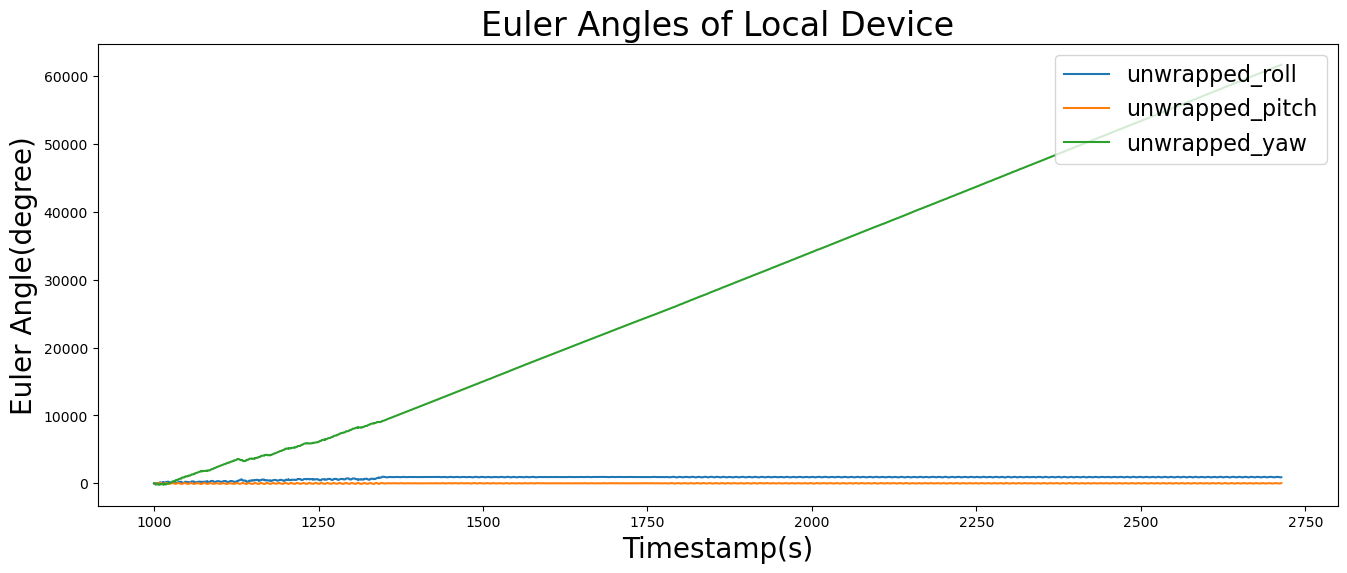

In [19]:
data_plot_G = pd.DataFrame(cropped_df, columns=["Seconds", "unwrapped_roll", "unwrapped_pitch", "unwrapped_yaw"])
data_plot_G.plot(x="Seconds", y=["unwrapped_roll", "unwrapped_pitch", "unwrapped_yaw"], figsize=(16, 6))
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Euler Angle(degree)', fontsize="20")
plt.title("Euler Angles of Local Device", fontsize="24")
plt.legend(fontsize="16", loc ="upper right")
plt.show()

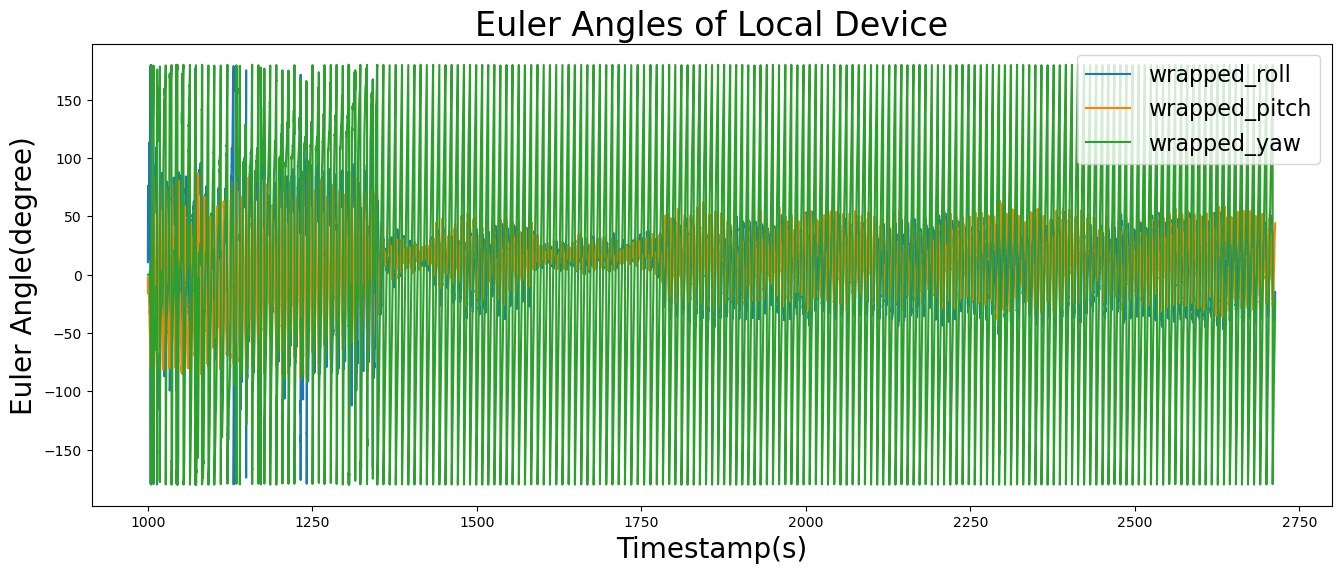

In [20]:
data_plot_G = pd.DataFrame(cropped_df, columns=["Seconds", "wrapped_roll", "wrapped_pitch", "wrapped_yaw",])
data_plot_G.plot(x="Seconds", y=["wrapped_roll", "wrapped_pitch", "wrapped_yaw"], figsize=(16, 6))
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Euler Angle(degree)', fontsize="20")
plt.title("Euler Angles of Local Device", fontsize="24")
plt.legend(fontsize="16", loc ="upper right")
# plt.xlim(1300,1450)
plt.show()

In [65]:
### Wrapped angles

In [66]:
# for a_hr, a_rr, xl in zip(['wrapped_r_hr', 'wrapped_p_hr', 'wrapped_y_hr'],['wrapped_r_rr', 'wrapped_p_rr', 'wrapped_y_rr'], ['wrapped_roll',  'wrapped_pitch',  'wrapped_yaw']):
#     # fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
#     cropped_df[a_hr] = butter_bandpass_filter(cropped_df[xl], xl, lowcut_hr, highcut_hr, fs, order=4)
#     cropped_df[a_rr] = butter_bandpass_filter(cropped_df[xl], xl, lowcut_rr, highcut_rr, fs, order=4)
#     plt.legend(['a_hr', 'a_rr'])

# # cropped_df['x_rr'] = butter_bandpass_filter(cropped_df['XL_X'], 'XL_X_RR', lowcut_rr, highcut_rr, fs, order=4)
# # cropped_df['y_rr'] = butter_bandpass_filter(cropped_df['XL_Y'], 'XL_Y_RR', lowcut_rr, highcut_rr, fs, order=4)
# # cropped_df['z_rr'] = butter_bandpass_filter(cropped_df['XL_Z'], 'XL_Z_RR', lowcut_rr, highcut_rr, fs, order=4)

# # cropped_df

In [67]:
# ## Plot Predicted Data

# data_plot_G = pd.DataFrame(cropped_df, columns=["Seconds", "wrapped_r_hr", "wrapped_p_hr", "wrapped_y_hr"])
# data_plot_G.plot(x="Seconds", y=["wrapped_r_hr", "wrapped_p_hr", "wrapped_y_hr"], figsize=(16, 6))
# plt.xlabel('Timestamp(s)', fontsize="20")
# plt.ylabel('Amplitude', fontsize="20")
# plt.title("Filtered signal for HR", fontsize="24")
# plt.legend(fontsize="16", loc ="upper right")
# # plt.xlim(1200,1250)
# plt.show()

In [68]:
# data_plot_G = pd.DataFrame(cropped_df, columns=["Seconds", "wrapped_r_rr", "wrapped_p_rr", "wrapped_y_rr"])
# data_plot_G.plot(x="Seconds", y=["wrapped_r_rr", "wrapped_p_rr","wrapped_y_rr"], figsize=(16, 6))
# plt.xlabel('Timestamp(s)', fontsize="20")
# plt.ylabel('Amplitude', fontsize="20")
# plt.title("Filtered signal for RR", fontsize="24")
# plt.legend(fontsize="16", loc ="upper right")
# # plt.xlim(1200,1250)
# plt.show()

In [ ]:
#### Unwrapped angles

In [21]:
for a_hr, a_rr, xl in zip(['unwrapped_r_hr', 'unwrapped_p_hr', 'unwrapped_y_hr'],['unwrapped_r_rr', 'unwrapped_p_rr', 'unwrapped_y_rr'], ['unwrapped_roll',  'unwrapped_pitch',  'unwrapped_yaw']):
    # fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
    cropped_df[a_hr] = butter_bandpass_filter(cropped_df[xl], xl, lowcut_hr, highcut_hr, fs, order=4)
    cropped_df[a_rr] = butter_bandpass_filter(cropped_df[xl], xl, lowcut_rr, highcut_rr, fs, order=4)
    # plt.legend(['a_hr', 'a_rr'])

# cropped_df['x_rr'] = butter_bandpass_filter(cropped_df['XL_X'], 'XL_X_RR', lowcut_rr, highcut_rr, fs, order=4)
# cropped_df['y_rr'] = butter_bandpass_filter(cropped_df['XL_Y'], 'XL_Y_RR', lowcut_rr, highcut_rr, fs, order=4)
# cropped_df['z_rr'] = butter_bandpass_filter(cropped_df['XL_Z'], 'XL_Z_RR', lowcut_rr, highcut_rr, fs, order=4)

# cropped_df

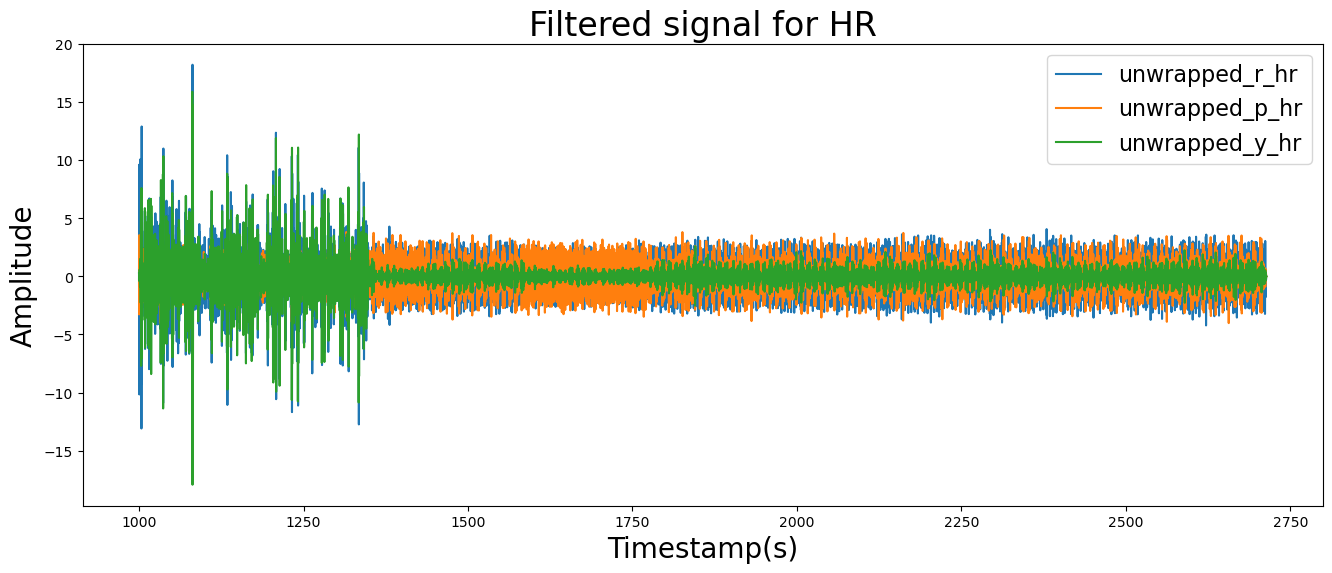

In [22]:
## Plot Predicted Data

data_plot_G = pd.DataFrame(cropped_df, columns=["Seconds", "unwrapped_r_hr", "unwrapped_p_hr", "unwrapped_y_hr"])
data_plot_G.plot(x="Seconds", y=["unwrapped_r_hr", "unwrapped_p_hr", "unwrapped_y_hr"], figsize=(16, 6))
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Amplitude', fontsize="20")
plt.title("Filtered signal for HR", fontsize="24")
plt.legend(fontsize="16", loc ="upper right")
# plt.xlim(1200,1250)
plt.show()

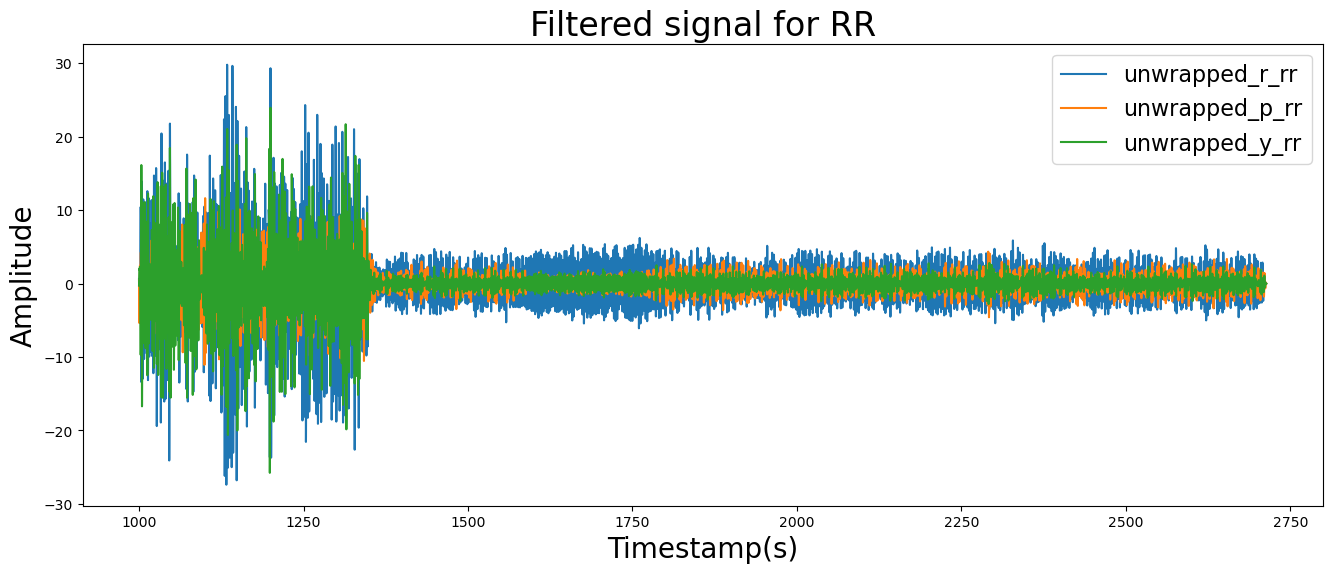

In [23]:
data_plot_G = pd.DataFrame(cropped_df, columns=["Seconds", "unwrapped_r_rr", "unwrapped_p_rr", "unwrapped_y_rr"])
data_plot_G.plot(x="Seconds", y=["unwrapped_r_rr", "unwrapped_p_rr", "unwrapped_y_rr"], figsize=(16, 6))
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Amplitude', fontsize="20")
plt.title("Filtered signal for RR", fontsize="24")
plt.legend(fontsize="16", loc ="upper right")
# plt.xlim(1200,1250)
plt.show()

In [73]:
def getSTD(timeseries):
    """
    Method to get mean pressure over considered timeframe.

    :param timeseries: (Array) Array containing pressure data from a given time interval (day/stresstest/etc.) for one specific pressure (ABP/ICP/etc.).
    :return: (float) Standard deviation of pressure data.
    """
    return timeseries.std()

In [295]:
# Define interval #
start = 1000
end = 2713
interval = cropped_df.loc[(cropped_df['Seconds'] >= start) & (cropped_df['Seconds'] <= end)] # interval is a DataFrame
dur = end - start

# Adjust #
w = 100 # in amount of points (try 208 samplesa larger window (1040) and increment in between)

lowcut_hr = 1.8 # heart rate lower bound for bandpass filtering
highcut_hr = 2.5 # heart rate upper bound for bandpass filtering
lowcut_rr = 0.33 # respiratory rate lower bound for bandpass filtering
highcut_rr = 0.66 # respiratory rate upper bound for bandpass filtering

In [186]:
# ### Peak detection for plotting###



# # Crop the time window eliminating the first and the last w/2 points
# signal_w = interval.iloc[int(w/2):len(time)-int(w/2)]
# time_w = interval.iloc[int(w/2):len(time)-int(w/2)]

# hr_pm = []
# rr_pm = []
# ### From Abby (modified)


# # Relevant signal #
# mysignal = interval.unwrapped_r_hr.values # array
# time = interval.Seconds.values  	      # array


# #upper_thresh, lower_thresh, peaks_corrected, valleys_corrected, mov_avg
# mov_avg = (np.convolve(mysignal, np.ones(w), 'same') / w)[int(w/2):len(mysignal)-int(w/2)]

# factor = 1
# upper_thresh = mov_avg + factor*getSTD(mov_avg)
# lower_thresh = mov_avg - factor*getSTD(mov_avg)



# # Crop the time window eliminating the first and the last w/2 points
# window = interval.iloc[int(w/2):len(time)-int(w/2)]


# # Detect peaks in windowed signal
# peak_idx, _ = signal.find_peaks(window.unwrapped_r_hr.values, height=upper_thresh)
# valley_idx, _ = signal.find_peaks(-window.unwrapped_r_hr.values, height=-lower_thresh)

# # Interval for plotting
# plot_interval = window


# # All peaks
# peaks = plot_interval.iloc[peak_idx]
# valleys = plot_interval.iloc[valley_idx]



# # ## Computing width based on prominence
# # # Compute widths in windowed signal
# # peak_width = signal.peak_widths(signal_w, peak_idx, 1.0) # in amount of samples
# # valley_width = signal.peak_widths(-signal_w, valley_idx, 1.0)


# # # Valid peaks
# # peaks_corrected = peak_idx[np.where((1/lowcut_hr*fs > peak_width[0]) & (peak_width[0] > 1/highcut_hr*fs))]
# # valleys_corrected = valley_idx[np.where((1/lowcut_hr*fs > valley_width[0]) & (valley_width[0] > 1/highcut_hr*fs))]


# ## Computing width based on distance peak to peak
# peak_width_2 = np.roll(window.unwrapped_r_hr.values[peak_idx],-1) - window.unwrapped_r_hr.values[peak_idx] # in seconds
# peaks_corrected = peak_idx[np.where((1/lowcut_hr > peak_width_2) & (peak_width_2 > 1/highcut_hr))]

# valley_width_2 = window.unwrapped_r_hr.values[peak_idx] -  np.roll(window.unwrapped_r_hr.values[peak_idx],1) # in seconds
# valleys_corrected = valley_idx[np.where((1/lowcut_hr > valley_width_2) & (valley_width_2 > 1/highcut_hr))]


# # elif start == 'peak':
# #     peak_width_2 = time_w[valley_idx] - np.roll(time_w[valley_idx],-1) # in seconds
# #     peaks_corrected = peak_idx[np.where((1/lowcut_hr > peak_width_2) & (peak_width_2 > 1/highcut_hr))]

# #     valley_width_2 = np.roll(time_w[peak_idx],-1) - time_w[peak_idx] # in seconds
# #     valleys_corrected = valley_idx[np.where((1/lowcut_hr > valley_width_2) & (valley_width_2 > 1/highcut_hr))]

In [302]:
# Function for peak detection


def peak_detection(myDataFrame, signal_column, w, std_factor, method, lowcut, highcut):
    """
    w: window size for moving average
    std_factor: factor for the standard deviation of moving average to reduce noise
    signal_column: not a str
    method: 
        peak_to_peak_dis
        widths
    Returns:
    
    """    
    
    # Crop the time window eliminating the first and the last w/2 points
    window = myDataFrame.iloc[int(w/2):len(myDataFrame)-int(w/2)]

    # Crop the time window eliminating the first and the last w/2 points
    signal_w = window[signal_column].values
    # print(signal_w)
    time_w = window.Seconds.values
    
    hr_pm = []
    rr_pm = []
    ### From Abby (modified)



    #upper_thresh, lower_thresh, peaks_corrected, valleys_corrected, mov_avg
    mov_avg = (np.convolve(signal_w, np.ones(w), 'same') / w)

    factor = 1
    upper_thresh = mov_avg + std_factor*getSTD(mov_avg)
    lower_thresh = mov_avg - std_factor*getSTD(mov_avg)




    # Detect peaks in windowed signal
    peak_idx, _ = signal.find_peaks(signal_w, height=upper_thresh)
    valley_idx, _ = signal.find_peaks(-signal_w, height=-lower_thresh)   
    
    # All peaks
    peaks_df = window.iloc[peak_idx]
    valleys_df = window.iloc[valley_idx]

    peaks = peaks_df[signal_column].values
    valleys = valleys_df[signal_column].values
    
    ## Computing width based on distance peak to peak
    if method == 'peak_to_peak_dis':
        peak_width = np.roll(peaks,-1) - peaks # in seconds
        peaks_corrected = peak_idx[np.where((1/lowcut > peak_width) & (peak_width > 1/highcut))]
        
        valley_width = valleys -  np.roll(valleys,1) # in seconds
        valleys_corrected = valley_idx[np.where((1/lowcut_hr > valley_width) & (valley_width > 1/highcut))]

    elif method == 'widths':
        # ## Computing width based on prominence
        # Compute widths in windowed signal
        peak_width = signal.peak_widths(signal_w, peak_idx, 1.0) # in amount of samples
        valley_width = signal.peak_widths(-signal_w, valley_idx, 1.0)
        
    
        # Valid peaks
        peaks_corrected = peak_idx[np.where((1/lowcut_hr*fs > peak_width[0]) & (peak_width[0] > 1/highcut*fs))]
        valleys_corrected = valley_idx[np.where((1/lowcut_hr*fs > valley_width[0]) & (valley_width[0] > 1/highcut*fs))]

    return window, peaks_df, valleys_df, peaks, valleys, upper_thresh, lower_thresh, peaks_corrected, valleys_corrected, signal_w, time_w, mov_avg

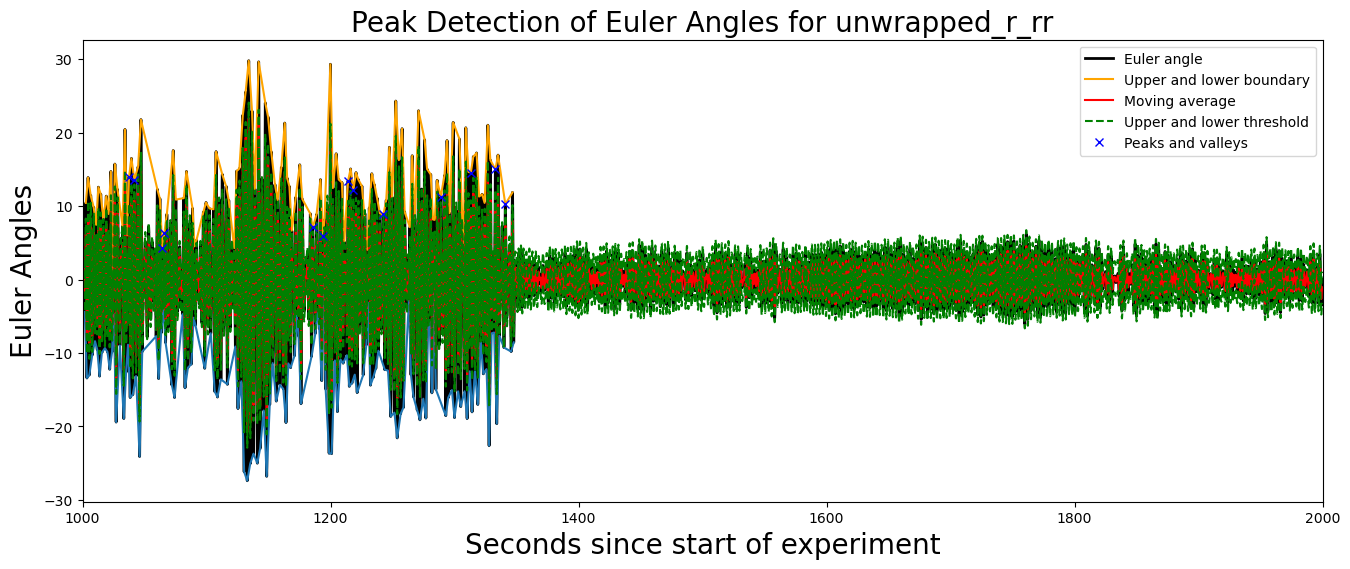

In [303]:
# Plot peak detection
col = 'unwrapped_r_rr'
window, peaks_df, valleys_df, peaks, valleys, upper_thresh, lower_thresh, peaks_corrected, valleys_corrected, signal_w, time_w, mov_avg = peak_detection(interval, col,104, 0.5,'peak_to_peak_dis',lowcut_rr, highcut_rr)

fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
#ax.set_ylabel('Angle(degree)')
#ax.set_xlabel('Time(second)')
a1 = ax.plot(window['Seconds'], window[col], color='black',linewidth=2.0, label = 'Euler angle')
a2 = ax.plot(peaks_df['Seconds'], peaks_df[col], color='orange', label = 'Upper and lower boundary')
a3 = ax.plot(valleys_df['Seconds'], valleys_df[col])
a4 = ax.plot(window['Seconds'], mov_avg, color='red', label = 'Moving average')
a5 = ax.plot(time_w, upper_thresh, color='green', linestyle='dashed', label = 'Upper and lower threshold')
a6 = ax.plot(time_w, lower_thresh, color='green', linestyle='dashed')
a7 = ax.plot(time_w[peaks_corrected], signal_w[peaks_corrected], 'x', color='blue', label = 'Peaks and valleys')
a8 = ax.plot(time_w[valleys_corrected], signal_w[valleys_corrected], 'x', color='blue')
#ax.legend(loc='upper left')
# #plt.xlim(7060,7660)
# #plt.ylim((-12, -2))
# ax.legend(fontsize="12")
plt.xlabel('Seconds since start of experiment', fontsize="20")
plt.ylabel('Euler Angles', fontsize="20")
plt.title(f"Peak Detection of Euler Angles for {col}", fontsize="20")
# #plt.savefig('peak_detect_pitch.png')
plt.xlim(1000, 2000)
ax.legend()
plt.show()


In [300]:
cropped_df['Seconds']

Time
2024-09-19 09:53:37.026040000    1000.000040
2024-09-19 09:53:37.035655385    1000.009655
2024-09-19 09:53:37.045270770    1000.019271
2024-09-19 09:53:37.054886155    1000.028886
2024-09-19 09:53:37.064501540    1000.038502
                                    ...     
2024-09-19 10:22:10.247262375    2713.221262
2024-09-19 10:22:10.256877760    2713.230878
2024-09-19 10:22:10.266493145    2713.240493
2024-09-19 10:22:10.276108530    2713.250109
2024-09-19 10:22:10.285723915    2713.259724
Name: Seconds, Length: 178180, dtype: float64

In [184]:
### Peak detection by interval ###

### From Abby (modified)

# Define interval #
start = 1000
end = 1500
interval = cropped_df.loc[(cropped_df['Seconds'] >= start) & (cropped_df['Seconds'] <= end)] # interval is a DataFrame
dur = end - start

# -------


valid_intervals_hr = [] # List of tuples. Each tuple represents a valid interval
valid_intervals_rr = [] # List of tuples. Each tuple represents a valid interval


# Crop the time window eliminating the first and the last w/2 points
window = interval.iloc[int(w/2):len(time)-int(w/2)]

hr_pm = []
rr_pm = []

for i, g in window.groupby(pd.Grouper(freq='1min', closed='right')):  
    #Choose an axis randomly (for now)
    mysignal = g.unwrapped_p_hr.values # array
    time = g.Seconds.values  	       # array
    
    #upper_thresh, lower_thresh, peaks_corrected, valleys_corrected, mov_avg
    mov_avg = (np.convolve(mysignal, np.ones(w), 'same') / w)
    
    factor = 1
    upper_thresh = mov_avg + factor*getSTD(mov_avg)
    lower_thresh = mov_avg - factor*getSTD(mov_avg)
        
    # Detect peaks in interval
    peak_idx, _ = signal.find_peaks(mysignal, height=upper_thresh)
    valley_idx, _ = signal.find_peaks(-mysignal, height=-lower_thresh)
    
  
    # All peaks
    peaks = g.iloc[peak_idx]
    valleys = g.iloc[valley_idx]
    
    
    estimates = [] #RR estimates for each interval between peaks

    for i,ix in enumerate(peak_idx):
        if i>0:
            last_ix = peak_idx[i-1]
            delta = g.iloc[ix]['Seconds'] - g.iloc[last_ix]['Seconds']
            
            hr_this_interval = 1/delta
            if lowcut_hr < hr_this_interval < highcut_hr:
                estimates.append(hr_this_interval*60)
                valid_intervals_hr.append((g.iloc[last_ix]['Seconds'], g.iloc[ix]['Seconds']))

            # print(estimates)
    this_median = np.median(estimates)
    # print(this_median)
    
    # hr_pm_2.append(this_median)
    hr_pm.append([g['Seconds'].iloc[0], this_median])
    # print(estimates)
        
    

[431]


In [181]:
hr_pm

[[1000.48080925, nan]]

In [108]:
peaks

,Time,XL_X,XL_Y,XL_Z,G_X,G_Y,G_Z,Temperature,Voltage,Packet,...,unwrapped_yaw,wrapped_roll,wrapped_pitch,wrapped_yaw,unwrapped_r_hr,unwrapped_r_rr,unwrapped_p_hr,unwrapped_p_rr,unwrapped_y_hr,unwrapped_y_rr
Time,,,,,,,,,,,,,,,,,,,,,
2024-09-19 09:53:41.651040185,2024-09-19 09:53:41.651040185,0.66,-0.37,0.71,-7.14,-25.8,-12.43,41.0,3.007,11939,...,-103.260877,171.558929,-47.111103,-134.676804,0.235723,9.955661,-2.338733,8.045576,3.151067,-16.077531


In [145]:
# # Plot peak detection
# fig, ax = plt.subplots()
# fig.set_size_inches(16, 6)
# #ax.set_ylabel('Angle(degree)')
# #ax.set_xlabel('Time(second)')
# a1 = ax.plot(plot_interval['Seconds'], plot_interval['unwrapped_r_rr'], color='black',linewidth=2.0, label = 'Euler angle')
# a2 = ax.plot(peaks['Seconds'], peaks['unwrapped_r_rr'], color='orange', label = 'Upper and lower boundary')
# a3 = ax.plot(valleys['Seconds'], valleys['unwrapped_r_rr'])
# a4 = ax.plot(plot_interval['Seconds'], mov_avg, color='red', label = 'Moving average')
# a5 = ax.plot(time_w, upper_thresh, color='green', linestyle='dashed', label = 'Upper and lower threshold')
# a6 = ax.plot(time_w, lower_thresh, color='green', linestyle='dashed')
# a7 = ax.plot(time_w[peaks_corrected], signal_w[peaks_corrected], 'x', color='blue', label = 'Peaks and valleys')
# a8 = ax.plot(time_w[valleys_corrected], signal_w[valleys_corrected], 'x', color='blue')
# # #ax.legend(loc='upper left')
# # #plt.xlim(7060,7660)
# # #plt.ylim((-12, -2))
# # ax.legend(fontsize="12")
# # plt.xlabel('Timestamp(s)', fontsize="20")
# # plt.ylabel('Euler Angle(degree)', fontsize="20")
# # plt.title("Peak Detection of Euler Angles in Roll Axis of Local Device (10 minutes)", fontsize="24")
# # #plt.savefig('peak_detect_pitch.png')
# start, end = 1200, 1210
# for sec in np.arange(start, end+1, 1):
#     ax.axvline(sec, color='grey', linestyle='--', linewidth=0.8, alpha=0.7)

# plt.xlim(1200, 1300)
# plt.show()


In [144]:
# Import ground data to compare:

g_file = r"C:\Users\krisf\OneDrive\Desktop\UROP SU25\Ceara sleep detection\Modified Data\ground\ground_09192024.csv"
g_data = pd.read_csv(g_file, header = header, dtype = str, delimiter = ',', names = ['Hour', 'Minute', 'Second','HR', 'RR'])
g_df = pd.DataFrame(g_data, columns=['Hour', 'Minute', 'Second', "HR", "RR"])

g_df["HR"] = pd.to_numeric(g_df["HR"], errors="coerce")
g_df["RR"] = pd.to_numeric(g_df["RR"], errors="coerce")

times = g_df[['Hour','Minute','Second']].astype(str).agg(':'.join, axis=1)

g_df['Time'] = pd.to_datetime('09192024'+' '+times+'.000', format='%m%d%Y %H:%M:%S.%f')

g_df = g_df.drop(['Hour','Minute','Second'], axis=1)

delta = g_df['Time'] - study_time
g_df['Seconds'] = delta.dt.total_seconds()
g_df['Seconds'] = pd.to_numeric(g_df['Seconds'], errors="coerce")
g_df


# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
# ax1.plot(g_df['Seconds'], g_df['HR'], label='Ground HR')
# ax1.plot(df_hr_pm_2['Seconds'], df_hr_pm_2['HR'], label='Predicted HR')
# ax1.set_xlabel('Seconds (s) from start')
# ax1.set_ylabel('Heart Rate')
# ax1.set_title('Overlapped HR from Two Files')
# ax1.legend()



# ax2.plot(g_df['Seconds'], g_df['RR'], label='Ground RR')
# ax2.plot(df_rr_pm_2['Seconds'], df_rr_pm_2['RR'], label='Predicted RR')
# ax2.set_xlabel('Seconds (s) from start')
# ax2.set_ylabel('Respiratory Rate')
# ax2.set_title('Overlapped RR from Two Files')
# ax2.legend()

,HR,RR,Time,Seconds
0,121,27,2024-09-19 09:54:00,1022.974
1,121,28,2024-09-19 09:54:01,1023.974
2,121,28,2024-09-19 09:54:02,1024.974
3,121,28,2024-09-19 09:54:03,1025.974
4,122,28,2024-09-19 09:54:04,1026.974
...,...,...,...,...
835,118,23,2024-09-19 10:07:55,1857.974
836,118,23,2024-09-19 10:07:56,1858.974
837,118,23,2024-09-19 10:07:57,1859.974
838,118,23,2024-09-19 10:07:58,1860.974


In [ ]:
# Plot peak to peak distance